1) Итог - на представленной выборке, настройка гиперпараметров не дает особых улучшений, скорее всего потому что изначально на идет переобучения. Удалось вуйграть 0,01 - 0,015 максимум, при этом эти значения меньше тех отклонений которые возникают на тестовой выборке.

2) Выводы сделанные на этапе подготовки данных о том какие данные оставлять, а какие убирать могут быть не совсем корректны - наверное нужно было делать различные комбинации засовывать в цикл - и уже с этим работать - так искать самую оптимальную модель + наверное не мудрить со столбцом времени а сделать более простые (но менее логичные) данные, например время прошедшее с подачи.

3) Если говорить о гиперпараметрах как и в случае модели - набо было всовывать все параметры и перебирать по ним. Я же пытался понять поможет это в данно конкретном случае или нет, скорее всего нужно было перебреать все параметры так как положительное может дать именно их комбинация. 

In [714]:
from scipy.stats import ttest_ind
import time
import calendar as cal
from pandas.tseries.offsets import Day, BDay
from datetime import date

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from scipy.stats import ttest_ind
import seaborn as sns

In [715]:
def boxplot_ttest(df, col_name_values, col_name_param):
    '''Статистическое сравнение t-тестом Стьюдента и построение box plot для столбцов с двумя категориями'''

    if df[col_name_param].dropna().nunique() == 2:
        uniq_bins = df[col_name_param].dropna().unique()
        # display(uniq_bins)
        #display(list(df[(df[col_name_param] == uniq_bins[1])][col_name_values].dropna()))
        stat_result = ttest_ind(df.loc[(df[col_name_param] == uniq_bins[0])][col_name_values].dropna(
        ), df.loc[(df[col_name_param] == uniq_bins[1])][col_name_values].dropna())
        if stat_result.pvalue <= 0.05:
            print("p-value: {};".format(round(stat_result[1], 10)), 'Значения в колонке ',
                  col_name_param, 'достоверно различаются (alpha = 0.05)')
        else:
            print("p-value: {};".format(round(stat_result[1], 10)), 'Значения в колонке ',
                  col_name_param, 'достоверно не различаются (alpha = 0.05)')
        sns.boxplot(x=col_name_param, y=col_name_values, data=df)
        return stat_result
    else:
        return 0

In [716]:
def del_outliers(df, column_name):
    ''''''
    df1 = df[df['Train']==1]
    c = len(df1)
    df2 = df[df['Train']==0] 
    
    a = df1.describe()
    quart = 1.5*(a.iloc[6] - a.iloc[4])
    q3 = a.iloc[6]
    q1 = a.iloc[4]
    df1.loc[(df1[column_name] > q3[column_name]+quart[column_name]) |
           (df1[column_name] < q1[column_name]-quart[column_name]), column_name] = None
    df1 = df1.dropna()
    print(c - len(df1))
    print(len(df2))
    
    new_df = pd.concat([df1, df2], ignore_index=True)
    return new_df

def data_prep(df, bin_cols_fin, cat_cols_fin, num_cols_fin, size):
    '''из pandas формируем тестовую и обучающие выборки'''
    X_cat = OneHotEncoder(sparse = False).fit_transform(df[df['Train']==1][cat_cols_fin].values)
    X_cat.shape
    X_num = RobustScaler().fit_transform(df[df['Train']==1][num_cols_fin].values)
    X = np.hstack([X_num, df[df['Train']==1][bin_cols].values, X_cat])
    Y = df[df['Train']==1]['default'].values
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=size)
    
    return X_train, X_test, y_train, y_test
    
    

In [717]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [718]:
# для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['Train'] = 1 # помечаем где у нас трейн
df_test['Train'] = 0 # помечаем где у нас тест

df = pd.concat([df_train, df_test], ignore_index=True)

In [719]:
df

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,Train
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0.0,1
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0.0,1
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0.0,1
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0.0,1
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,83775,31MAR2014,SCH,F,37,N,N,1,0,-1.744976,3,50,2,3,15000,4,1,N,NaN,0
110144,106254,25APR2014,GRD,F,64,Y,Y,0,0,-2.293781,3,60,1,2,200000,1,4,N,NaN,0
110145,81852,30MAR2014,GRD,M,31,N,N,2,0,-0.940752,1,50,1,2,60000,4,2,N,NaN,0
110146,1971,07JAN2014,UGR,F,27,N,N,1,0,-1.242392,2,80,2,3,30000,1,1,N,NaN,0


In [720]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

данные с пропусками - только в строке с образованием, следовательно заполняем его двумя способами - 
1) самым частым значением (education)
2) строим классификационную предсказательную модель и заполняем (education_2) - после работы с колонками

1) самое частое значение

In [721]:
df['education_2'] = df['education']
df.education = df.education.fillna(df['education'].value_counts().index[0])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         110148 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

работаем со столбцом дата подачи заявки - преобразуем в год, месяц и день

In [722]:
df['len_data'] = df['app_date'].apply(lambda x: len(x))
# все значения в едином формате - поэтому можно просто отсечь значения
display(df['len_data'].value_counts())

months = {'JAN': 1, 'FEB': 2, 'MAR': 3, 'APR': 4, 'MAY': 5, 'JUN': 6,
          'JUL': 7, 'AUG': 8, 'SEP': 9, 'OCT': 10, 'NOV': 11, 'DEC': 12}
df['date'] = df['app_date'].apply(lambda x: [int(x[0:2]), int(months[x[2:5]]), int(x[-4:])])

df['day'] = df['date'].apply(lambda x: x[0])
# выборка клиентов только по 4 месяцам -
df['month']=df['date'].apply(lambda x: x[1])
                                                    # если тестовые данные будут с другими месяцами то это знатно испортит - уберем
# год только 2014 - удалим из рассмотрения после обработки
df['year']=df['date'].apply(lambda x: x[2])

bdays=BDay()
df['workday'] = df['date'].apply(lambda x: bdays.is_on_offset(date(x[2],x[1],x[0]))) # рабочие дни

df['time_till_pay'] = df['day'].apply(lambda x: x in [5,6,7,8,9,20,21,22,23,24]) # время до зп

del df['day']
del df['month']
del df['year']
del df['date']
del df['len_data']
del df['app_date']

df

9    110148
Name: len_data, dtype: int64

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,work_address,income,sna,first_time,foreign_passport,default,Train,education_2,workday,time_till_pay
0,25905,SCH,M,62,Y,Y,0,0,-2.008753,1,...,2,18000,4,1,N,0.0,1,SCH,False,False
1,63161,SCH,F,59,N,N,0,0,-1.532276,3,...,3,19000,4,1,N,0.0,1,SCH,True,False
2,25887,SCH,M,25,Y,N,2,0,-1.408142,1,...,2,30000,1,4,Y,0.0,1,SCH,False,False
3,16222,SCH,F,53,N,N,0,0,-2.057471,2,...,3,10000,1,3,N,0.0,1,SCH,True,True
4,101655,GRD,M,48,N,N,0,1,-1.244723,1,...,3,30000,1,4,Y,0.0,1,GRD,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,83775,SCH,F,37,N,N,1,0,-1.744976,3,...,3,15000,4,1,N,NaN,0,SCH,True,False
110144,106254,GRD,F,64,Y,Y,0,0,-2.293781,3,...,2,200000,1,4,N,NaN,0,GRD,True,False
110145,81852,GRD,M,31,N,N,2,0,-0.940752,1,...,2,60000,4,2,N,NaN,0,GRD,False,False
110146,1971,UGR,F,27,N,N,1,0,-1.242392,2,...,3,30000,1,1,N,NaN,0,UGR,True,True


есть предложение - посмотреть рабочий это день ли нет + заявка за 5 дней до стандартных дней зарплаты и аванса () или нет (попытка оценить причину взятия кредита - есть ли у человека деньги или нет перед авансом и зарплатой)

[64427, 9372]
[0.0, 1.0]


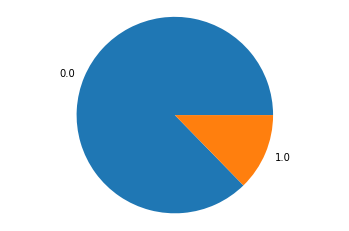

In [723]:
default = df[df['Train'] == 1]['default'].value_counts()
vals = [default[0], default[1]]
print(vals)
labels = [default.index[0], default.index[1]]
print(labels)

fig, ax = plt.subplots()
ax.pie(vals, labels=labels)
ax.axis("equal")
plt.show()

наш целевой признак - default распределен неравномерно - нужно будет с этим бороться

разбиваем на колонки численные, бинарные и категориальные

In [724]:
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport', 'workday', 'time_till_pay']
cat_cols = ['education', 'work_address', 'home_address','sna','first_time','region_rating']
num_cols = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt','score_bki']

работаем с непрерывными переменными

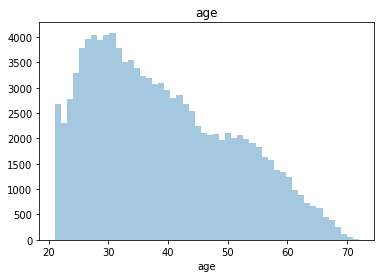

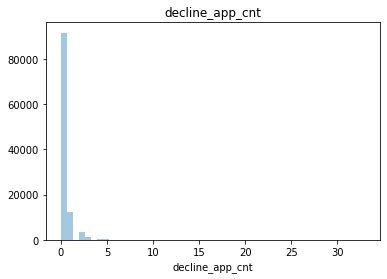

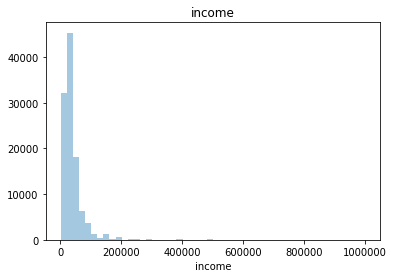

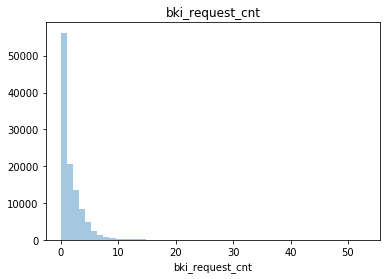

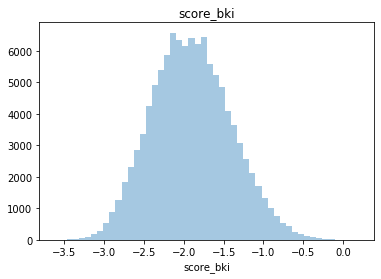

In [725]:
for i in num_cols:
    plt.figure()
    sns.distplot(df[i], kde = False, rug=False)
    plt.title(i)
    plt.show()

Применяем логарифмирование ко всем столбцам кроме score_bki, который распределен нормально

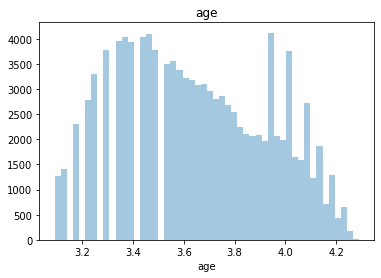

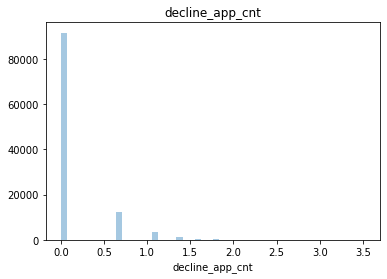

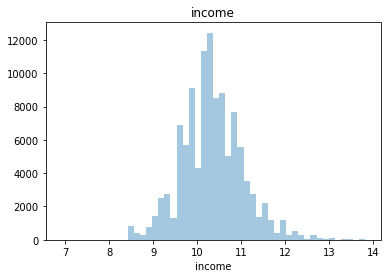

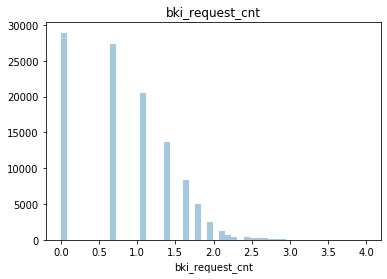

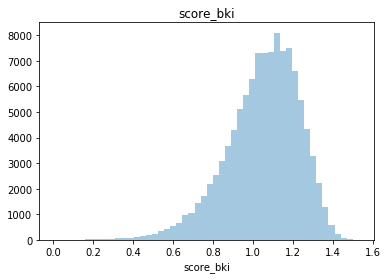

In [726]:
for i in num_cols:
    df[i] = df[i].apply(lambda x: np.log(np.abs(x)+1))
    #df[i][df[i] > 0].dropna()

for i in num_cols:
    plt.figure()
    sns.distplot(df[i], kde = False, rug=False)
    plt.title(i)
    plt.show()

проверяем ttest и boxplot

p-value: 0.0; Значения в колонке  default достоверно различаются (alpha = 0.05)


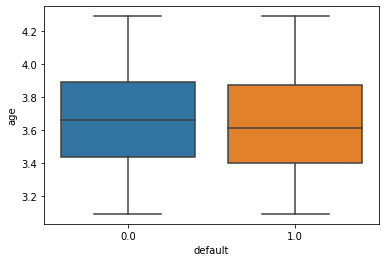

In [727]:
stat_results = boxplot_ttest(df, 'age', 'default')

p-value: 0.0; Значения в колонке  default достоверно различаются (alpha = 0.05)


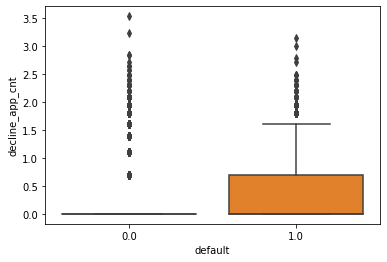

In [728]:
stat_results = boxplot_ttest(df, 'decline_app_cnt', 'default')

p-value: 0.0; Значения в колонке  default достоверно различаются (alpha = 0.05)


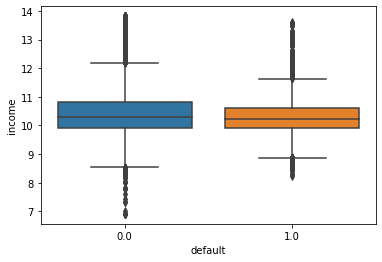

In [729]:
stat_results = boxplot_ttest(df, 'income', 'default')

p-value: 0.0; Значения в колонке  default достоверно различаются (alpha = 0.05)


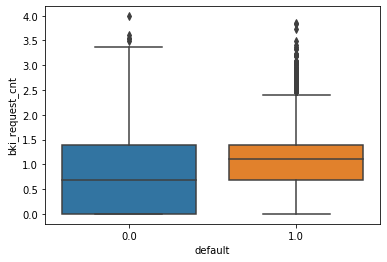

In [730]:
stat_results = boxplot_ttest(df, 'bki_request_cnt', 'default')

p-value: 0.0; Значения в колонке  default достоверно различаются (alpha = 0.05)


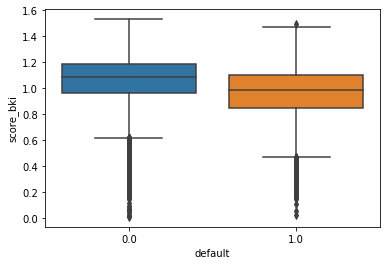

In [731]:
stat_results = boxplot_ttest(df, 'score_bki', 'default')

Проверяем какие компроненты непрерывных переменных самые важные + попробуем ввести переменную перемножения - skore_bki и decline_app_cnt на (рейтинг региона - будет типа взвешивающим коэффициентом)

In [732]:
df['score_bki_weigh'] = df['score_bki']+np.log(df['region_rating'])
df['decline_app_cnt_weigh'] = df['decline_app_cnt']+np.log(df['region_rating'])
num_cols = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt','score_bki', 'score_bki_weigh', 'decline_app_cnt_weigh']

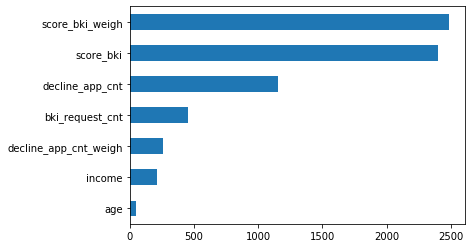

In [733]:
imp_num = pd.Series(f_classif(
    df[df['Train'] == 1][num_cols], df[df['Train'] == 1]['default'])[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

По сравнению с первой выборкой - новый параметр score_bki намного более, 
попробовать на score_bki и decline_app_cnt корень, квадрат, куб!! (bki_request_cnt????)

взвешенный по рейтингу района score_bki - лучше 
decline_weigh - хуже, убираем

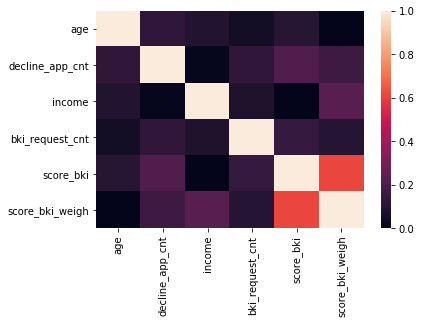

In [734]:
del df['decline_app_cnt_weigh']
num_cols = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt','score_bki', 'score_bki_weigh']
sns.heatmap(df[num_cols].corr().abs(), vmin=0, vmax=1)

Корреляций нет - используем все признаки. score_ski - используем либо обычный либо взвешенный

In [735]:
# добавляем различные комбинации степеней - 2, 3
df['score_bki_2'] = df['score_bki'].apply(lambda x: x**2)
df['score_bki_3'] = df['score_bki'].apply(lambda x: x**3)

df['score_bki_weigh_2'] = df['score_bki_weigh'].apply(lambda x: x**2)
df['score_bki_weigh_3'] = df['score_bki_weigh'].apply(lambda x: x**3)

df['decline_app_cnt_2'] = df['decline_app_cnt'].apply(lambda x: x**2)
df['decline_app_cnt_3'] = df['decline_app_cnt'].apply(lambda x: x**3)

проверим и эти данные на то лучше они ли нет

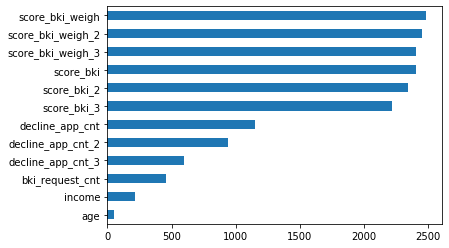

In [736]:
num_cols_ex = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt',
               'score_bki', 'score_bki_2', 'score_bki_3',
               'score_bki_weigh', 'score_bki_weigh_2', 'score_bki_weigh_3',
               'decline_app_cnt_2', 'decline_app_cnt_3']

imp_num = pd.Series(f_classif(
    df[df['Train'] == 1][num_cols_ex], df[df['Train'] == 1]['default'])[0], index=num_cols_ex)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

квадраты и кубы работают хуже чем линейная зависимость - не рассматриваем их в модели.

ВОПРОС: Правильно ли так делать - или лучше все-таки проверить на модели. 

работаем с bin колонками

In [737]:
label_encoder = LabelEncoder()

for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])

df['education'] = label_encoder.fit_transform(df['education'])
    
# убедимся в преобразовании    
df.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,education_2,workday,time_till_pay,score_bki_weigh,score_bki_2,score_bki_3,score_bki_weigh_2,score_bki_weigh_3,decline_app_cnt_2,decline_app_cnt_3
0,25905,3,1,4.143135,1,1,0.000000,0,1.101526,0.693147,...,SCH,0,0,5.013549,1.213359,1.336546,25.135670,126.018907,0.000000,0.000000
1,63161,3,0,4.094345,0,0,0.000000,0,0.929119,1.386294,...,SCH,1,0,4.841142,0.863261,0.802072,23.436652,113.460150,0.000000,0.000000
2,25887,3,1,3.258097,1,0,1.098612,0,0.878856,0.693147,...,SCH,0,0,5.260882,0.772387,0.678817,27.676882,145.604817,1.206949,1.325969
3,16222,3,0,3.988984,0,0,0.000000,0,1.117588,1.098612,...,SCH,1,1,5.029611,1.249003,1.395872,25.296989,127.234020,0.000000,0.000000
4,101655,1,1,3.891820,0,0,0.000000,1,0.808582,0.693147,...,GRD,1,0,4.902927,0.653805,0.528655,24.038689,117.859927,0.000000,0.000000


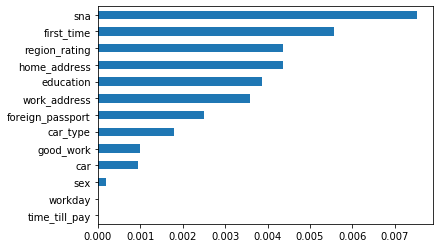

In [738]:
imp_cat = pd.Series(mutual_info_classif(df[df['Train'] == 1][bin_cols + cat_cols], df[df['Train'] == 1]['default'],
                                        discrete_features=True), index=bin_cols + cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

три новых признака - имеют самый большой вес. К сожалению наши призкани из даты обращения крайне плохи(( - их наверное лучше убрать + 3 самых которые не влияют. 

In [739]:
bin_cols_fin = ['car_type', 'foreign_passport']
cat_cols_fin = ['education', 'work_address', 'home_address','sna','first_time', 'region_rating']
num_cols_fin = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt','score_bki_weigh','score_bki_weigh_2', 'score_bki_weigh_3']

работаем с категориальными данными для модели 

In [740]:
X_cat = OneHotEncoder(sparse = False).fit_transform(df[df['Train']==1][cat_cols_fin].values)
X_cat.shape

(73799, 26)

In [741]:
X_num = RobustScaler().fit_transform(df[df['Train']==1][num_cols_fin].values)

In [742]:
X = np.hstack([X_num, df[df['Train']==1][bin_cols].values, X_cat])
Y = df[df['Train']==1]['default'].values

In [743]:
Y.shape

(73799,)

In [744]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30)

Решаем с помощью LogisticRegressionCV()

In [745]:
C = np.logspace(0, 20)
modelCV = LogisticRegressionCV(Cs = C, cv=5, max_iter=500, scoring = 'f1', multi_class = 'multinomial')
modelCV.fit(X_train, y_train)
y_predicted_CV = modelCV.predict(X_test)

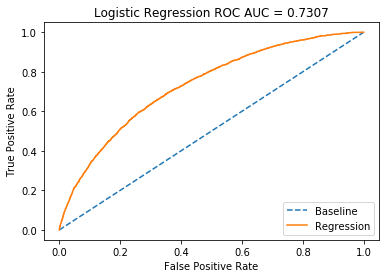

In [746]:
probs = modelCV.predict_proba(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.4f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

результат - ROC AUC = 0.7351

Теперь пробуем настраивать через GridSearchCV

In [651]:
model = LogisticRegression(max_iter = 200)
model.fit(X_train, y_train)
y_predicted = model.predict(X_test)

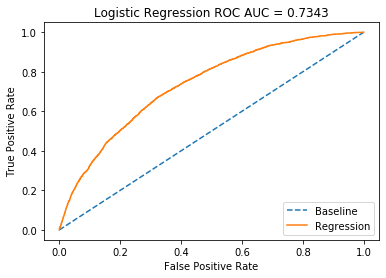

In [652]:
probs = model.predict_proba(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.4f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

подберем оптимальные гиперпараметры модели

In [653]:
from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l2']
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'] 

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty, solver=solver)

model = LogisticRegression(max_iter = 200)
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])
print('Лучший solver:', best_model.best_estimator_.get_params()['solver'])

C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which 

C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which 

C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which 

C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which 

C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which 

C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which 

C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which 

C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which 

C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which 

C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which 

C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which 

C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which 

C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which 

C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\320071926\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which 

Лучшее C: 1.0
Лучший solver: lbfgs


Результат показал, что 
Лучшее C: 1.599858719606058
Лучший solver: lbfgs

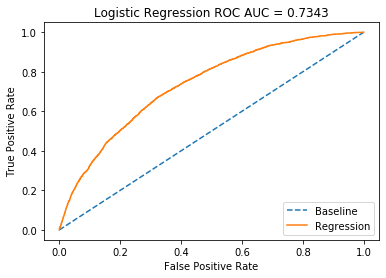

In [654]:
y_predicted_bM = best_model.predict(X_test)
probs = best_model.predict_proba(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.4f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()


лучшее что может дать на валидационной выборке GridSearchCV - ROC AUC = 0.7343. Таким образом  LogisticRegressionCV и GridSearchCV работают +/- одинаково, при подборе параметров вышеперечисленных параметров.

попробуем загрузить лучший результат в kagle

In [660]:
df_sub = df[df['Train'] == 0][['client_id', 'default']]

X_cat_sub = OneHotEncoder(sparse = False).fit_transform(df[df['Train']==0][cat_cols_fin].values)
print(X_cat_sub.shape)
X_num_sub = StandardScaler().fit_transform(df[df['Train']==0][num_cols_fin].values)
print(X_num_sub.shape)
X_sub = np.hstack([X_num_sub, df[df['Train']==0][bin_cols].values, X_cat_sub])

probs_SV = best_model.predict_proba(X_sub)
probs_SV = probs_SV[:,1]

df_sub['default'] = probs_SV
df_sub
df_sub.to_csv('submission.csv', index=False)

(36349, 26)
(36349, 5)


Теперь попробуем избавиться от выбросов в переменных c постоянными значениями значениями. 
и упаковать вышеперечисленные модели в удобные функции

In [512]:
new_df = del_outliers(df, 'age')
new_df = del_outliers(new_df, 'income')
new_df = del_outliers(new_df, 'bki_request_cnt')


C:\Users\320071926\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


307
36349
1758
36349
7
36349


In [513]:
new_df

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,education_2,workday,time_till_pay,score_bki_weigh,score_bki_2,score_bki_3,score_bki_weigh_2,score_bki_weigh_3,decline_app_cnt_2,decline_app_cnt_3
0,25905,3,1,4.143135,1,1,0.000000,0,-2.008753,0.693147,...,SCH,0,0,-1.004376,4.035088,-8.105495,1.008772,-1.013187,0.000000,0.000000
1,63161,3,0,4.094345,0,0,0.000000,0,-1.532276,1.386294,...,SCH,1,0,-0.766138,2.347870,-3.597586,0.586968,-0.449698,0.000000,0.000000
2,25887,3,1,3.258097,1,0,1.098612,0,-1.408142,0.693147,...,SCH,0,0,-1.126514,1.982865,-2.792155,1.269033,-1.429584,1.206949,1.325969
3,16222,3,0,3.988984,0,0,0.000000,0,-2.057471,1.098612,...,SCH,1,1,-1.028736,4.233188,-8.709664,1.058297,-1.088708,0.000000,0.000000
4,101655,1,1,3.891820,0,0,0.000000,1,-1.244723,0.693147,...,GRD,1,0,-0.746834,1.549335,-1.928492,0.557760,-0.416554,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108071,83775,3,0,3.637586,0,0,0.693147,0,-1.744976,1.386294,...,SCH,1,0,-0.872488,3.044940,-5.313347,0.761235,-0.664168,0.480453,0.333025
108072,106254,1,0,4.174387,1,1,0.000000,0,-2.293781,1.386294,...,GRD,1,0,-1.376269,5.261433,-12.068579,1.894116,-2.606813,0.000000,0.000000
108073,81852,1,1,3.465736,0,0,1.098612,0,-0.940752,0.693147,...,GRD,0,0,-0.470376,0.885014,-0.832579,0.221254,-0.104072,1.206949,1.325969
108074,1971,4,0,3.332205,0,0,0.693147,0,-1.242392,1.098612,...,UGR,1,1,-0.993913,1.543537,-1.917678,0.987864,-0.981851,0.480453,0.333025


In [514]:
new_df

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,education_2,workday,time_till_pay,score_bki_weigh,score_bki_2,score_bki_3,score_bki_weigh_2,score_bki_weigh_3,decline_app_cnt_2,decline_app_cnt_3
0,25905,3,1,4.143135,1,1,0.000000,0,-2.008753,0.693147,...,SCH,0,0,-1.004376,4.035088,-8.105495,1.008772,-1.013187,0.000000,0.000000
1,63161,3,0,4.094345,0,0,0.000000,0,-1.532276,1.386294,...,SCH,1,0,-0.766138,2.347870,-3.597586,0.586968,-0.449698,0.000000,0.000000
2,25887,3,1,3.258097,1,0,1.098612,0,-1.408142,0.693147,...,SCH,0,0,-1.126514,1.982865,-2.792155,1.269033,-1.429584,1.206949,1.325969
3,16222,3,0,3.988984,0,0,0.000000,0,-2.057471,1.098612,...,SCH,1,1,-1.028736,4.233188,-8.709664,1.058297,-1.088708,0.000000,0.000000
4,101655,1,1,3.891820,0,0,0.000000,1,-1.244723,0.693147,...,GRD,1,0,-0.746834,1.549335,-1.928492,0.557760,-0.416554,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108071,83775,3,0,3.637586,0,0,0.693147,0,-1.744976,1.386294,...,SCH,1,0,-0.872488,3.044940,-5.313347,0.761235,-0.664168,0.480453,0.333025
108072,106254,1,0,4.174387,1,1,0.000000,0,-2.293781,1.386294,...,GRD,1,0,-1.376269,5.261433,-12.068579,1.894116,-2.606813,0.000000,0.000000
108073,81852,1,1,3.465736,0,0,1.098612,0,-0.940752,0.693147,...,GRD,0,0,-0.470376,0.885014,-0.832579,0.221254,-0.104072,1.206949,1.325969
108074,1971,4,0,3.332205,0,0,0.693147,0,-1.242392,1.098612,...,UGR,1,1,-0.993913,1.543537,-1.917678,0.987864,-0.981851,0.480453,0.333025


In [527]:
bin_cols_fin_woo = ['car_type', 'foreign_passport']
cat_cols_fin_woo = ['education', 'work_address', 'home_address','sna','first_time','region_rating']
num_cols_fin_woo = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt','score_bki_weigh']

In [657]:
X_train, X_test, y_train, y_test = data_prep(new_df, bin_cols_fin_woo, cat_cols_fin_woo, num_cols_fin_woo, 0.30)

In [658]:
C = np.logspace(0, 10)
modelCV_woo = LogisticRegressionCV(Cs = C, cv=5, max_iter=200, scoring = 'f1')
modelCV_woo.fit(X_train, y_train)
y_predicted_CV_woo = modelCV_woo.predict(X_test)

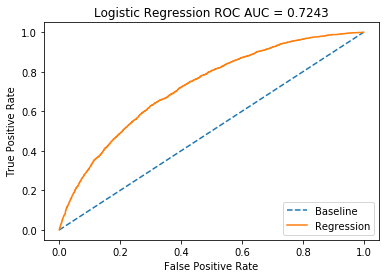

In [536]:
probs = modelCV_woo.predict_proba(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.4f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

удаление выбросов не приносит результат лучше на становиться лучше